# Vue with DRF 

django + Vue(pinia, router)

## CORS policy

**SOP** 
same-origin-policy

동일 출처 정책

어떤 출처(origin)에서 불러온 문서나 스크립트가 다른 출처에서 가져온 리소스와 상호작용하는 것을 제한하는 보안 방식

웹 애플리케이션의 도메인이 다른 도메인의 리소스에 접근하는 것을 제어하여 사용자의 개인 정보와 데이터의 보안을 보호하고, 잠재적인 보안 위협을 방지

잠재적으로 해로울 수 있는 문서를 분리함으로써 공격받을 수 있는 경로를 줄임

https://developer.mozilla.org/en-US/docs/Web/Security/Same-origin_policy


**origin(출처)**

URL의 protocol, host, port 모두가 출처. 이 모두가 일치해야 동일 출처(same-origin)으로 인정

그래서 django server와 vue server는 다른 출처의 데이터이고 블락된 것.

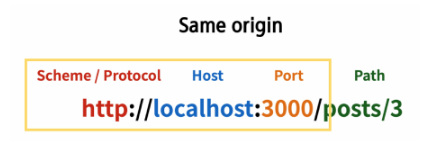

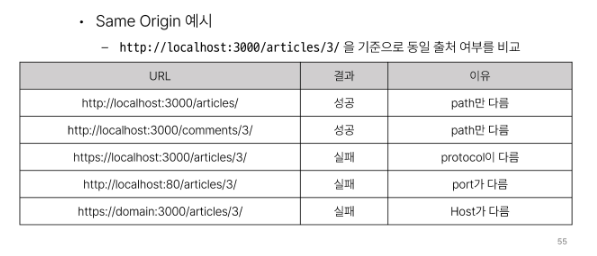

**CORS Policy의 등장**

기본적으로 웹 브라우저는 같은 출처에서만 요청하는 것을 허용, 다른 출처로의 요청은 보안상의 이유로 차단됨.

--> CORS의 필요성. 웹 서버가 리소스에 대한 서로 다른 출처 간 접근을 허용하도록 선택할 수 있는 기능을 제공

**CORS**

Cross-Origin Resource Sharing

교차 출처 리소스 공유

- 특정 출처(origin)에서 실행 중인 웹 애플리케이션이 다른 출처의 자원에 접근할 수 있는 권한을 부여하도록 브라우저에 알려주는 체제

DRF가 브라우저에 알려줘야 함.

CORS Policy (교차 출처 리소스 공유 정책): 다른 출처에서 온 리소스를 공유하는 것에 대한 정책

서버에서 설정되며, 브라우저가 해당 정책을 확인하여 요청 허용 여부 결정.

다른 출처의 리소스를 불러오려면 그 출처에서 올바른 CORS header를 포함한 응답을 반환해야 함

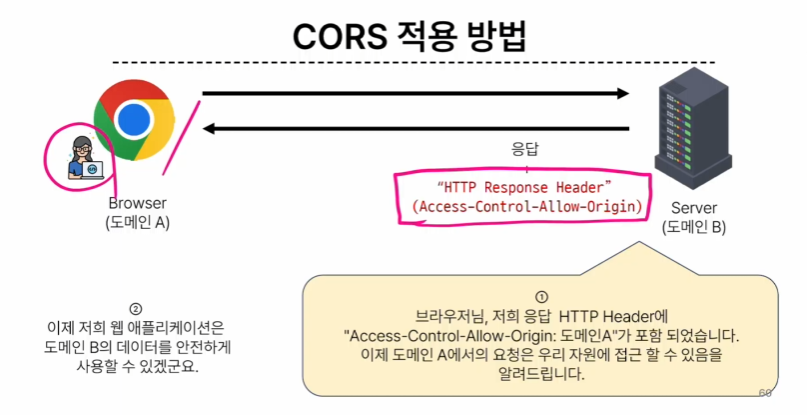

https://developer.mozilla.org/ko/docs/Web/HTTP/CORS


## CORS Headers 설정

django에서는 django-cors-headers library 활용(응답 객체에 CORS header를 추가해주는 라이브러리)

https://github.com/adamchainz/django-cors-headers

```
<!-- terminal -->
pip install django-cors-headers

<!-- settings.py -->
<!-- 추가 -->
INSTALLED_APPS= [
    "corsheaders",
]
<!-- 추가 -->
MIDDLEWARE = [
    'corsheaders.middleware.CorsMiddleware',    
]
<!-- 여기에 등록된 도메인은 허용됨 -->
CORS_ALLOWED_ORIGINS = [
    'http://127.0.0.1:5173',
    'http://localhost:5173',
]

```


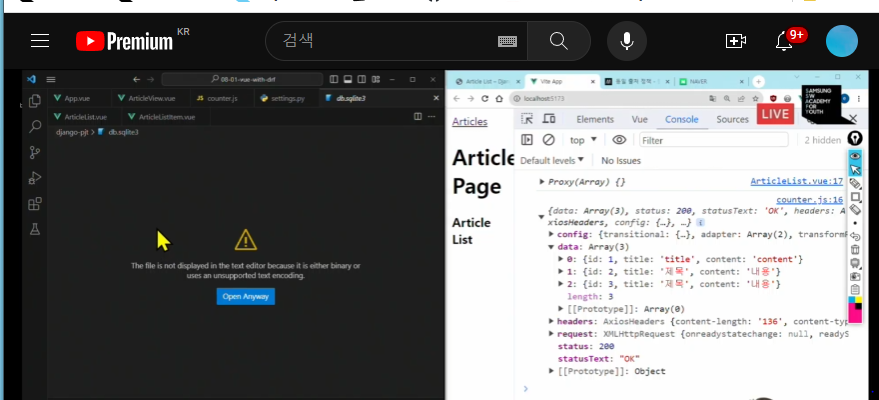

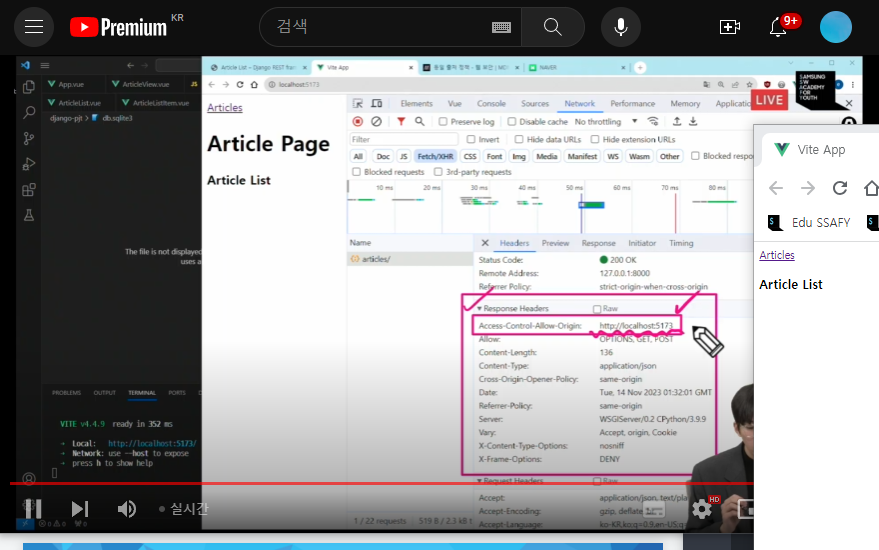



## Article CR 구현


CSRF가 필요없음- django가 만든게 아니라 vue가 만든 페이지에서 데이터 보냄--> CORS가 해결


### 라이브 코드

In [ ]:
<!-- App.vue -->

<template>
    <header>
      <nav>
        <RouterLink :to="{name:'ArticleView'}">Articles</RouterLink>
      </nav>
    </header>
    <RouterView />
  </template>
  
  <script setup>
  import { RouterLink,RouterView } from 'vue-router'
  </script>
  
  <style scoped>
  </style>
  

In [ ]:
<!-- ArticleView.vue -->

<template>
    <div>
      <h1>Article Page</h1>
      <RouterLink :to="{name:'CreateView'}">
      [CREATE]
      </RouterLink>
      <ArticleList />
    </div>
  </template>
  
  <script setup>
  import ArticleList from "@/components/ArticleList.vue"
  import { onMounted } from "vue";
  import { useCounterStore } from "@/stores/counter";
  import { RouterLink } from "vue-router";
  
  const store = useCounterStore()
  
  // mount 될 때 실행하겠다.
  onMounted(()=> {
    store.getArticles()
  })
  </script>
  
  <style>
  
  </style>
  

In [ ]:
<!-- ArticleList.vue -->

<template>
    <div>
      <h3>Article List</h3>
      <ArticleListItem 
      v-for="article in store.articles"
      :key="article.id"
      :article="article"/>
    </div>
  </template>
  
  <script setup>
  import ArticleListItem from '@/components/ArticleListItem.vue'
  import { useCounterStore } from "@/stores/counter"
  const store = useCounterStore()
  
  
  </script>
  


In [ ]:
<!-- ArticleListItem.vue -->

<template>
    <div>
      <h5> {{ article.id }} </h5>
      <p>{{ article.title }}</p>
      <p>{{ article.content }}</p>
      <RouterLink :to="{name:'DetailView', params:{ id: article.id}}"> 
        [Detail] 
      </RouterLink>
      <hr>
    </div>
  </template>
  
  <script setup>
  import { RouterLink} from 'vue-router';
  
  defineProps({
    article: Object
  })
  </script>
  

In [ ]:
<!-- DetailView.vue -->

<template>
    <div>
      <h1>Detail</h1>
      <div v-if="article">
        <p> {{ article.title }} </p>
        <p> {{ article.content }} </p>
        <p> {{ article.created_at }} </p>
        <p> {{ article.updated_at }} </p>
      </div>
    </div>
  </template>
  
  <script setup>
  import axios from 'axios';
  import { onMounted } from 'vue';
  import { useCounterStore } from '../stores/counter';
  import { useRoute } from 'vue-router';
  import { ref } from "vue"
  
  const store = useCounterStore()
  const route = useRoute()
  
  const article = ref(null)
  onMounted(()=> {
    axios({
      method: "get",
      url: `${store.API_URL}/api/v1/articles/${route.params.id}/`
    })
    .then((res)=>{
      console.log(res.data)
      article.value = res.data
    })
    .catch((err)=>{
      console.log(err)
    })
  })
  
  </script>
  
  <style>
  
  </style>
  

In [ ]:
<!-- CreateView.vue -->

<template>
    <div>
      <h1>게시글 작성</h1>
      <form @submit.prevent="createArticle">
        <input type="text" v-model.trim="title">
        <textarea v-model.trim="content"></textarea>
        <input type="submit">
      </form>
    </div>
  </template>
  
  <script setup>
  import { ref } from "vue"
  import { useCounterStore } from "../stores/counter";
  import axios from "axios"
  import { useRouter } from "vue-router";
  
  const store = useCounterStore()
  const router = useRouter()
  
  const title = ref(null)
  const content = ref(null)
  
  const createArticle = function ( ){
    axios({
      method: "post",
      url: `${store.API_URL}/api/v1/articles/`,
      data:{
        title: title.value,
        content: content.value
      }
    })
    .then((res)=>{
      console.log(res)
      router.push({name:'ArticleView'})
    })
    .catch((err)=> {
      console.log(err)
    })
  }
  
  </script>
  
  <style>
  
  </style>
  

In [ ]:
// counter.js

import { ref, computed } from 'vue'
import { defineStore } from 'pinia'
import axios from "axios"

export const useCounterStore = defineStore('counter', () => {
  const articles = ref([])
  const API_URL = "http://127.0.0.1:8000"

  // DRF에 article 조회 요청을 보내는 action
  const getArticles = function() {
    axios({
      method: "get",
      url: `${API_URL}/api/v1/articles/`
    })
    .then((res)=>{
      // console.log(res)
      articles.value = res.data
    })
    .catch((err)=>{
      console.log(err)
    })
  }



  return { articles, API_URL, getArticles }
}, { persist: true })


In [ ]:
// index.js

import { createRouter, createWebHistory } from 'vue-router'
import ArticleView from '@/views/ArticleView.vue'
import DetailView from '@/views/DetailView.vue'
import CreateView from '@/views/CreateView.vue'
// import SignUpView from '@/views/SignUpView.vue'
// import LogInView from '@/views/LogInView.vue'

const router = createRouter({
  history: createWebHistory(import.meta.env.BASE_URL),
  routes: [
    {
      path: '/',
      name: 'ArticleView',
      component: ArticleView
    },
    {
      path: '/articles/:id',
      name: 'DetailView',
      component: DetailView
    },
    {
      path: '/create',
      name: 'CreateView',
      component: CreateView
    },
    // {
    //   path: '/signup',
    //   name: 'SignUpView',
    //   component: SignUpView
    // },
    // {
    //   path: '/login',
    //   name: 'LogInView',
    //   component: LogInView
    // }
  ]
})

export default router
